# Chapter 6 Analysis of Yield Curves

In [215]:
# numerical and scientific computing libraries
import numpy as np
import scipy as sp

# plotting libraries 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [216]:
# for pretty printing
np.set_printoptions(4, linewidth=100, suppress=True)

## SVD of a financial time series: yield curves.

Let us download the yield curve data set from 'https://home.treasury.gov/interest-rates-data-csv-archive' and analyze it.

In [217]:
import pandas as pd

# Specify the path to your CSV file
csv_filename = 'treasury-yield-curve-rates-2019-2024.csv'
#csv_filename = 'GovtBondWeek.csv'

try:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_filename)

    # --- Display the data (optional) ---
    print("Successfully read CSV into DataFrame.")

    # Print the first 5 rows
    print("\nFirst 5 rows:")
    print(df.head())

    # Print DataFrame info (columns, data types, non-null counts)
    print("\nDataFrame Info:")
    df.info()

    # --- Now you can work with the DataFrame 'df' ---
    # Example: Access a column
    # print(df['column_name'])

except FileNotFoundError:
    print(f"Error: The file '{csv_filename}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
    
# identify issued date: daily, weekly, monthly
# convert the first column to datetime with a format
first_column = pd.to_datetime(df.iloc[:, 0], format='mixed')
if first_column[1] - first_column[0] > pd.Timedelta(days=20):
    issue_cycle = 'Monthly'
elif first_column[1] - first_column[0] > pd.Timedelta(days=5):
    issue_cycle = 'Weekly'
else:
    issue_cycle = 'Daily'
# extract the year of the first date
first_issue_year = first_column[0].year
# extract the year of the last date
last_issue_date = first_column.iloc[-1].year
print(issue_cycle, first_issue_year, last_issue_date)
#print(type(first_column))


Successfully read CSV into DataFrame.

First 5 rows:
       Date  1 Mo  2 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  \
0  12/31/24  4.40  4.39  4.37  4.24  4.16  4.25  4.27  4.38  4.48   4.58   
1  12/30/24  4.43  4.42  4.37  4.25  4.17  4.24  4.29  4.37  4.46   4.55   
2  12/27/24  4.44  4.43  4.31  4.29  4.20  4.31  4.36  4.45  4.53   4.62   
3  12/26/24  4.45  4.45  4.35  4.31  4.23  4.30  4.35  4.42  4.49   4.58   
4  12/24/24  4.44  4.44  4.40  4.30  4.24  4.29  4.36  4.43  4.52   4.59   

   20 Yr  30 Yr  
0   4.86   4.78  
1   4.84   4.77  
2   4.89   4.82  
3   4.83   4.76  
4   4.84   4.76  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1501 non-null   object 
 1   1 Mo    1501 non-null   float64
 2   2 Mo    1501 non-null   float64
 3   3 Mo    1501 non-null   float64
 4   6 Mo    1501 non-null   float64

In [218]:
# function converting Mo or Yr to Mo
def convert_to_months(duration_str):
    """
    Converts a duration string like 'X Mo' or 'Y Yr' into total months.

    Args:
        duration_str: The string representing the duration (e.g., '3 Mo', '2 Yr').

    Returns:
        An integer representing the total number of months,
        or None if the format is invalid.
    """
    if not isinstance(duration_str, str) or ' ' not in duration_str:
        return None # Return None for invalid input like NaN or bad format

    try:
        parts = duration_str.strip().split(' ')
        if len(parts) != 2:
            return None # Expect exactly two parts (number and unit)

        value = int(parts[0])
        unit = parts[1].strip().lower() # Use lower case for robust comparison

        if unit == 'mo':
            return value
        elif unit == 'yr':
            return value * 12
        else:
            return None # Unknown unit
    except ValueError:
        # Handle cases where the first part is not a valid integer
        return None
    except Exception:
        # Catch any other unexpected errors
        return None

In [220]:
# extract maturities and dates
maturity = df.columns
date_start = df.iloc[:,0]
colors = ['red', 'green', 'blue']
lines = ['-', '--', '-.']

# export the plot to a file
save_fig = False
if save_fig:
    fig_size = (5, 3)
else:
    fig_size = (8, 4)

# set maturity in month
maturity_month = []
for i in maturity[1:]:
    maturity_month.append(convert_to_months(i))
    
print("Maturity in months: ")
print(maturity_month)

# convert the selected sub-DataFrame to a NumPy array
sub_df = df.iloc[:, 1:]
yield_curve = sub_df.to_numpy()

print("Resulting NumPy array ", yield_curve.shape, ':')
print(yield_curve[:3,:])


Maturity in months: 
[1, 2, 3, 6, 12, 24, 36, 60, 84, 120, 240, 360]
Resulting NumPy array  (1501, 12) :
[[4.4  4.39 4.37 4.24 4.16 4.25 4.27 4.38 4.48 4.58 4.86 4.78]
 [4.43 4.42 4.37 4.25 4.17 4.24 4.29 4.37 4.46 4.55 4.84 4.77]
 [4.44 4.43 4.31 4.29 4.2  4.31 4.36 4.45 4.53 4.62 4.89 4.82]]


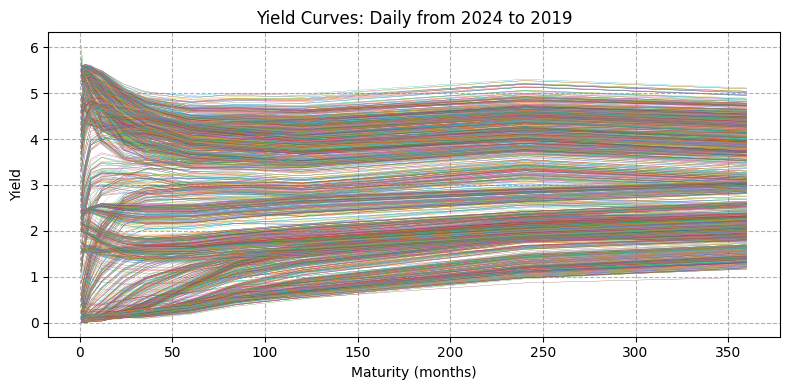

In [221]:
# plot yield curves
plt.figure(figsize=fig_size) # Adjust figure size as needed

for i in range(yield_curve.shape[0]):
    plt.plot(maturity_month, yield_curve[i,:], lw = 0.2)

if save_fig == False:
    plt.title('Yield Curves: ' + issue_cycle + ' from '+ str(first_issue_year) + ' to ' + str(last_issue_date))
plt.xlabel('Maturity (months)')
plt.ylabel('Yield')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout() # Adjust layout to prevent labels overlapping
if save_fig:
    # Save the figure to a file
    plt.savefig('yieldcurves.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [222]:
# compute compact SVD of Yield curves
mean_yield = np.mean(yield_curve, axis=0)
U, s, Vh = np.linalg.svd(yield_curve-mean_yield, full_matrices=False)
V = Vh.T
# fix the shape of the first 3 curves
sign_curve = np.sign(V[0,:3])*[1, 1, -1]
for i in range(3):
    V[:,i] = sign_curve[i]*V[:,i]
    U[:,i] = sign_curve[i]*U[:,i]

In [223]:
# explained variation
print(np.cumsum(s**2/np.sum(s**2)))

[0.9703 0.9935 0.9989 0.9996 0.9998 0.9999 0.9999 1.     1.     1.     1.     1.    ]


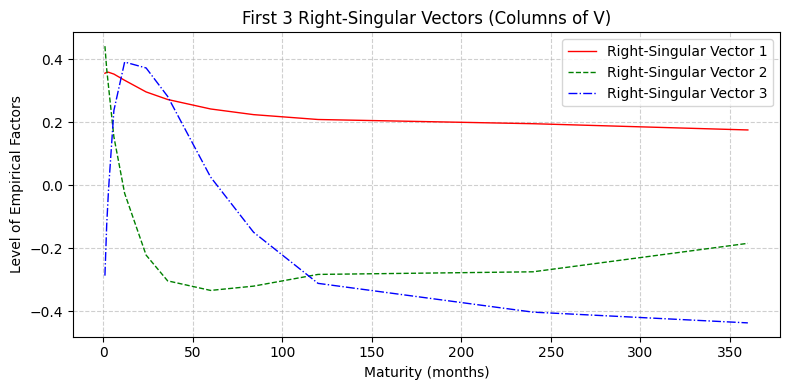

In [224]:
# plot the first 3 right-singular vectors
plt.figure(figsize=fig_size) # Adjust figure size as needed

for i in range(3):
    # Each column of V is a right-singular vector
    right_singular_vector = V[:,i]
    plt.plot(maturity_month, right_singular_vector, lw=1, ls=lines[i], c=colors[i], label=f'Right-Singular Vector {i+1}')

if save_fig == False:
    plt.title('First 3 Right-Singular Vectors (Columns of V)')
plt.xlabel('Maturity (months)')
plt.ylabel('Level of Empirical Factors')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
if save_fig:
    # Save the figure to a file
    plt.savefig('NS3.pdf', format='pdf', bbox_inches='tight')
plt.show()



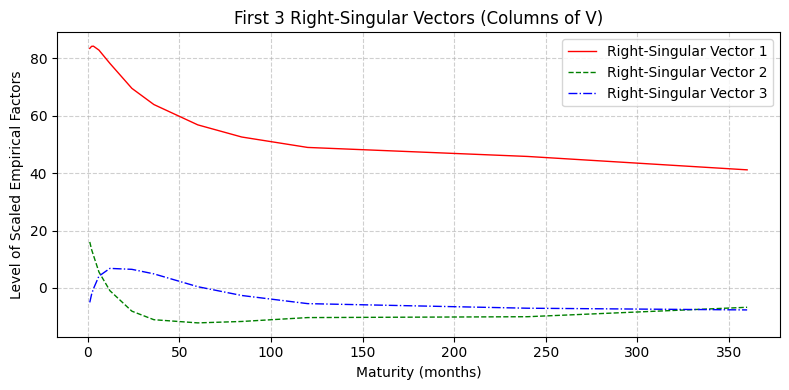

In [225]:
# plot the first 3 right-singular vectors scaled by singular values
plt.figure(figsize=fig_size) # Adjust figure size as needed

for i in range(3):
    # Each column of V is a right-singular vector
    right_singular_vector = V[:,i]*s[i]
    plt.plot(maturity_month, right_singular_vector, lw = 1, ls=lines[i], c=colors[i], label=f'Right-Singular Vector {i+1}')

if save_fig == False:
    plt.title('First 3 Right-Singular Vectors (Columns of V)')
plt.xlabel('Maturity (months)')
plt.ylabel('Level of Scaled Empirical Factors')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
if save_fig:
    # Save the figure to a file
    plt.savefig('NS3-scaled.pdf', format='pdf', bbox_inches='tight')
plt.show()

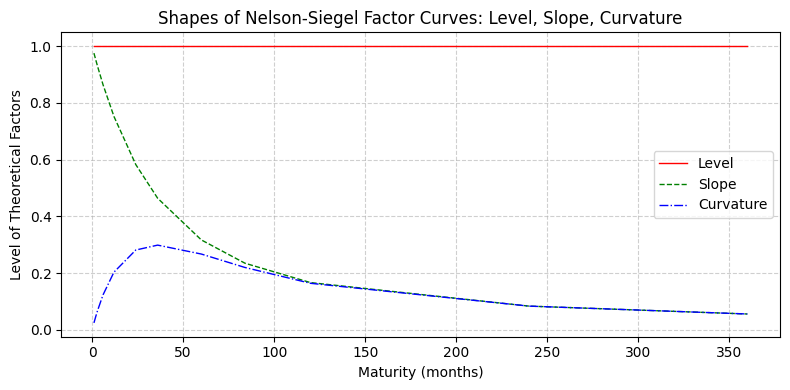

In [226]:
# plot the Nelson-Siegel factor curves
plt.figure(figsize=fig_size) # Adjust figure size as needed

# Theoretical Nelson-Siegel factor curves
maturity_year = np.array(maturity_month)/12
ns_lambda = 0.6
nelson_siegel_curves = np.ones((3, len(maturity_year)))
nelson_siegel_curves[1,:] = (1-np.exp(-maturity_year*ns_lambda))/(ns_lambda*maturity_year)
nelson_siegel_curves[2,:] = (1-np.exp(-maturity_year*ns_lambda))/(ns_lambda*maturity_year) - np.exp(-maturity_year*ns_lambda)

factors = ['Level', 'Slope', 'Curvature']

for i in range(3):
    # Each column of V is a right-singular vector
    plt.plot(maturity_month, nelson_siegel_curves[i,:], lw = 1, ls=lines[i], c=colors[i], label=factors[i])

if save_fig == False:
    plt.title('Shapes of Nelson-Siegel Factor Curves: Level, Slope, Curvature')
plt.xlabel('Maturity (months)')
plt.ylabel('Level of Theoretical Factors')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
if save_fig:
    # Save the figure to a file
    plt.savefig('ADNS.pdf', format='pdf', bbox_inches='tight')
plt.show()

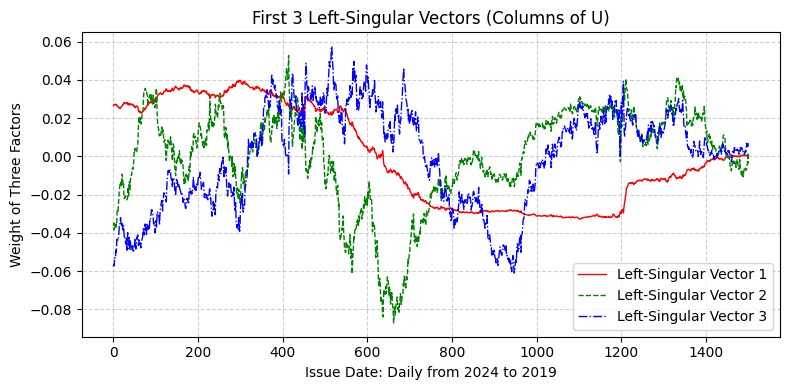

In [227]:
# --- Plot the first 3 left-singular vectors ---
plt.figure(figsize=fig_size) # Adjust figure size as needed

for i in range(3):
    # Each column of V is a left-singular vector
    left_singular_vector = U[:,i]
    plt.plot(left_singular_vector, lw = 1, ls=lines[i], c=colors[i], label=f'Left-Singular Vector {i+1}')

if save_fig == False:
    plt.title('First 3 Left-Singular Vectors (Columns of U)')
plt.xlabel('Issue Date: '+issue_cycle+' from '+ str(first_issue_year) + ' to ' + str(last_issue_date))
plt.ylabel('Weight of Three Factors')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
if save_fig:
    # Save the figure to a file
    plt.savefig('NS3LS.pdf', format='pdf', bbox_inches='tight')
plt.show()

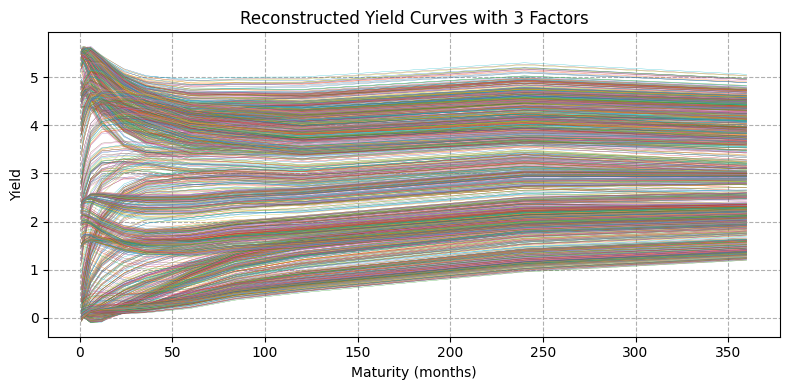

In [228]:
# plot the reconstructed yield curves using the first 3 factors
plt.figure(figsize=fig_size) # Adjust figure size as needed

for i in range(yield_curve.shape[0]):
    curve = U[i,:3] @ np.diag(s[:3]) @ V[:,:3].T + mean_yield
    plt.plot(maturity_month, curve, lw = 0.2)

if save_fig == False:
    plt.title('Reconstructed Yield Curves with 3 Factors')
plt.xlabel('Maturity (months)')
plt.ylabel('Yield')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout() # Adjust layout to prevent labels overlapping
if save_fig:
    # Save the figure to a file
    plt.savefig('approximate-yields-curves.pdf', format='pdf', bbox_inches='tight')
plt.show()